# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

Инструкция по выполнению проекта

Загрузите и подготовьте данные.
Обучите разные модели.
Сделайте выводы.

Описание данных

Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, make_scorer

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Подготовка

In [3]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv('toxic_comments.csv', index_col=0)

Saving toxic_comments.csv to toxic_comments.csv


In [4]:
data.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
data['text'].duplicated().sum()

np.int64(0)

In [6]:
data.isnull().sum()

,0
text,0
toxic,0


Дубликатов и пропусков нету.

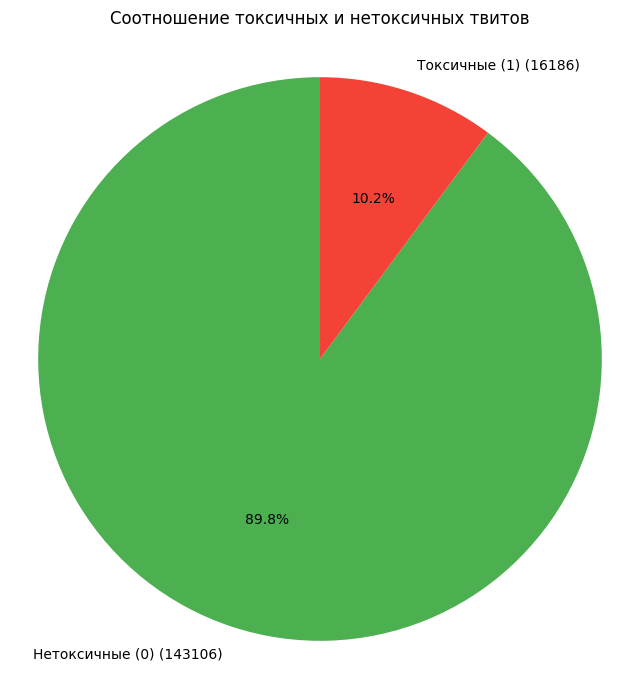

toxic
0    0.898388
1    0.101612
Name: proportion, dtype: float64


In [9]:
# Настройка цветов и подписей
colors = ['#4CAF50', '#F44336']  # 0, 1
labels = ['Нетоксичные (0)', 'Токсичные (1)']

# Создание круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(
    data['toxic'].value_counts(),
    labels=[f'{l} ({v})' for l, v in zip(labels, data['toxic'].value_counts())],
    colors=colors,
    autopct='%1.1f%%',
    startangle=90
)

# Добавление заголовка
plt.title('Соотношение токсичных и нетоксичных твитов', pad=20)
plt.axis('equal')

plt.show()

print(data['toxic'].value_counts(normalize=True))

Видим сильный дисбаланс классов, 90 на 10.

In [10]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [11]:
def lemmatize_with_pos(text):
    # Токенизация и получение POS-тегов
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    # Лемматизация с учетом POS
    lemmas = []
    for word, tag in pos_tags:
        wn_tag = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, wn_tag)
        lemmas.append(lemma)

    return ' '.join(lemmas)

In [14]:
data['cleaned_text'] = data['text'].apply(lemmatize_with_pos)

In [15]:
# Разделяем на признаки и целевую переменную
X = data['cleaned_text']
y = data['toxic']
# Разделяем на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение

Создаем пайплайн

In [16]:
# Создаем общий пайплайн
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=42))
])

In [17]:
# Параметры для GridSearchCV
parameters = [
    {
        'tfidf__max_features': [5000, 10000],
        'tfidf__ngram_range': [(1, 2)],
        'clf': [LogisticRegression(solver='liblinear')],
        'clf__C': [1, 10],
        'clf__penalty': ['l1', 'l2']
    },
    {
        'tfidf__max_features': [5000, 10000],
        'tfidf__ngram_range': [(1, 2)],
        'clf': [LinearSVC()],
        'clf__C': [1, 10],
        'clf__loss': ['hinge', 'squared_hinge']
    }
]

In [18]:
grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv=5,
                           scoring=make_scorer(f1_score),
                           verbose=1,
                           n_jobs=-1)

In [19]:
grid_search.fit(X_train, y_train)
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший F1-score:", grid_search.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры: {'clf': LogisticRegression(solver='liblinear'), 'clf__C': 1, 'clf__penalty': 'l1', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Лучший F1-score: 0.7703920321423469


In [20]:
# Оцениваем на тестовых данных
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test F1 Score:", f1_score(y_test, y_pred))

Test F1 Score: 0.7720430107526882


## Выводы

После предобработки данных, включая лемматизацию текста и снижение размерности признаков, был построен pipeline и проведено обучение моделей. Лучшая модель — LogisticRegression с параметрами:
solver='liblinear', C=1, penalty='l1', а также TfidfVectorizer(max_features=10000, ngram_range=(1, 2)).
Модель показала значение F1-метрики 0.77, что соответствует требованиям задания.